In [34]:
from pl_modules import *
from pl_datasets import *
import torch
import numpy as np
import random

In [2]:
 dm = NPDataModule(dataset_type='gpdata',
                      num_workers=4,
                      batch_size=16,
                      kernel='rbf',
                      num_samples=100,
                      num_points=100,
                      lengthscale_range=(0.25, 0.5),
                      sigma_range=(1,1),
                      )

In [18]:
model = PLNeuralProcess.load_from_checkpoint('/homes/gp491/AML/AML_neural_processes/1200_gp_rbf.ckpt')

In [130]:
rng = np.random.default_rng()


In [159]:
x, y, l, s, p = dm.val_dataloader().dataset.generate_gp_sample(rng)
model_x, model_y = torch.tensor(x).float().to(model.device).unsqueeze(0), torch.tensor(y).float().to(model.device).unsqueeze(0).unsqueeze(2)
kernel_type = dm.val_dataloader().dataset.kernel

In [24]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel

if kernel_type == 'rbf':
    kernel = ConstantKernel(s**2, constant_value_bounds = "fixed") * RBF(length_scale=l, length_scale_bounds="fixed")
elif kernel_type == 'matern':
    kernel = ConstantKernel(s**2, constant_value_bounds = "fixed") * Matern(length_scale=l, length_scale_bounds="fixed")
else:
    kernel = ConstantKernel(s**2, constant_value_bounds = "fixed") * ExpSineSquared(length_scale=l, length_scale_bounds="fixed", periodicity=p, periodicity_bounds="fixed")

gpr = GaussianProcessRegressor(kernel)

In [105]:
def random_search(x, y):
    min_id = np.argmin(y)
    rand_id = -1
    n = 0
    while not rand_id == min_id:
        n += 1
        rand_id = random.randint(0, x.shape[0] -1)
    return n

In [106]:
def random_search_no_rep(x, y):
    min_id = np.argmin(y)
    idxs = list(range(x.shape[0]))
    random.shuffle(idxs)
    return idxs.index(min_id) + 1   

In [234]:
def gp_thompson(x, y, kernel_type, s, l, p):
    
    if kernel_type == 'rbf':
        kernel = ConstantKernel(s**2, constant_value_bounds = "fixed") * RBF(length_scale=l, length_scale_bounds="fixed")
    elif kernel_type == 'matern':
        kernel = ConstantKernel(s**2, constant_value_bounds = "fixed") * Matern(length_scale=l, length_scale_bounds="fixed")
    else:
        kernel = ConstantKernel(s**2, constant_value_bounds = "fixed") * ExpSineSquared(length_scale=l, length_scale_bounds="fixed", periodicity=p,                                         periodicity_bounds="fixed")
    
    min_id = np.argmin(y)
    x_at_min = x[min_id]

    # print(f'min x {x_at_min}, min y {y[min_id]}' )
    
    sample_min = random.randint(0, x.shape[0]-1)
    next_x = x[sample_min]
    xs = np.array(next_x).reshape((-1, 1))
    ys = np.array(y[sample_min]).reshape((1, -1))
    gpr = GaussianProcessRegressor(kernel)

    while not (sample_min == min_id):
        # print(next_x)
        xs = xs.reshape((-1, 1))
        gpr.fit(xs, ys)
        sample = gpr.sample_y(x.reshape((-1, 1)))
        sample_min = np.argmin(sample)
        if xs.shape[0] > 150:
            # print(next_x, sample_min, min_id, sample[sample_min])
            # plt.plot(x, sample)
            # if xs.shape[0] > 53:
            #     plt.scatter(xs, ys)
            return  -1
        next_x = x[sample_min]

        xs = np.append(xs, next_x)
        ys = np.append(ys, y[sample_min])

    return xs.shape[0]


In [189]:
gp_thompson(x.flatten(), y, 'rbf', s, l, p)

min x 0.9595959595959598, min y -2.9393125537311464


8

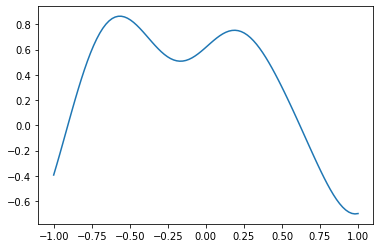

In [177]:
import  matplotlib.pyplot as plt

plt.plot(x, y)

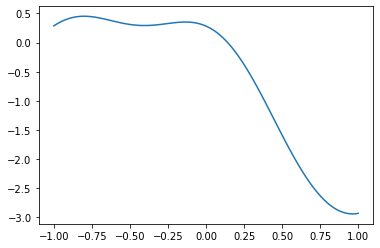

In [188]:
import  matplotlib.pyplot as plt

plt.plot(x, y)

In [190]:
def np_thompson(np_x, np_y, x, y, model):
    
    min_id = np.argmin(y)
    x_at_min = x[min_id]

    # print(f'min x {x_at_min}, min y {y[min_id]}' )
    
    rand_id = random.randint(0, x.shape[0]-1)
    next_x = x[rand_id]
    point_ids = [rand_id]
    while not (next_x == x_at_min):
        # print(next_x)
        x_context = np_x[:, point_ids, :]
        y_context = np_y[:, point_ids, :]

        p_y_pred, _, _ = model.model(x_context.to(model.device),
                                y_context.to(model.device),
                                np_x.to(model.device), None)

        sample = p_y_pred.loc.detach().cpu().numpy().flatten()
        sample_min = np.argmin(sample)
        
        next_x = x[sample_min]

        point_ids.append(sample_min)

        if len(point_ids) > 300:
            return  -1

    return len(point_ids)

In [238]:
model.eval()
np_vals = []
gp_vals = []
rand_vals = []
for i in range(3000):

    print('iteration ', i) 

    x, y, l, s, p = dm.val_dataloader().dataset.generate_gp_sample(rng)
    np_x, np_y = torch.tensor(x).float().to(model.device).unsqueeze(0), torch.tensor(y).float().to(model.device).unsqueeze(0).unsqueeze(2)
    kernel_type = dm.val_dataloader().dataset.kernel
    
    np_val = -1
    restarts = -1
    while np_val < 0:
        restarts += 1
        np_val = np_thompson(np_x, np_y, x.flatten(), y, model)
    print('NP: ', np_val, ' restarts ', restarts)

    gp_val = -1
    restarts = -1
    while gp_val < 0: 
        restarts += 1
        gp_val = gp_thompson(x.flatten(), y, 'rbf', s, l, p)
    print('GP: ', gp_val, ' restarts ', restarts)

    rand_val = random_search(x.flatten(), y)
    print(rand_val)

    np_vals.append(np_val)
    gp_vals.append(gp_val)
    rand_vals.append(rand_val)

  2667
NP:  27  restarts  0
GP:  11  restarts  0
56
iteration  2668
NP:  3  restarts  0
GP:  8  restarts  1
71
iteration  2669
NP:  20  restarts  0
GP:  8  restarts  0
236
iteration  2670
NP:  14  restarts  0
GP:  8  restarts  0
18
iteration  2671
NP:  59  restarts  0
GP:  6  restarts  0
111
iteration  2672
NP:  4  restarts  0
GP:  2  restarts  0
79
iteration  2673
NP:  24  restarts  0
GP:  6  restarts  0
37
iteration  2674
NP:  2  restarts  0
GP:  2  restarts  0
80
iteration  2675
NP:  29  restarts  0
GP:  8  restarts  0
123
iteration  2676
NP:  138  restarts  0
GP:  8  restarts  0
52
iteration  2677
NP:  9  restarts  0
GP:  5  restarts  0
95
iteration  2678
NP:  18  restarts  0
GP:  5  restarts  0
55
iteration  2679
NP:  4  restarts  0
GP:  8  restarts  0
93
iteration  2680
NP:  37  restarts  0
GP:  9  restarts  0
15
iteration  2681
NP:  34  restarts  0
GP:  7  restarts  0
109
iteration  2682
NP:  2  restarts  0
GP:  2  restarts  0
194
iteration  2683
NP:  44  restarts  0
GP:  7  res

In [239]:
rand_np = np.array(rand_vals)
gp_np = np.array(gp_vals)
np_np = np.array(np_vals)

In [240]:
print('Random mean steps ', np.mean(rand_np))
print('GP mean steps ', np.mean(gp_np))
print('NP mean steps ', np.mean(np_np) )

Random mean steps  100.315
GP mean steps  6.657
NP mean steps  36.37233333333333


In [241]:
print('Random mean steps (normalised) ', np.mean(rand_np)/np.mean(rand_np))
print('GP mean steps (normalised) ', np.mean(gp_np)/np.mean(rand_np))
print('NP mean steps (normalised) ', np.mean(np_np)/np.mean(rand_np) )

Random mean steps (normalised)  1.0
GP mean steps (normalised)  0.06636096296665504
NP mean steps (normalised)  0.36258120254531556


In [243]:
np.savez('thompson_3k.npz', rand_vals = rand_np, gp_vals = gp_np, np_vals = np_np)

In [202]:
def np_thompson_return_all(np_x, np_y, x, y, model):
    
    min_id = np.argmin(y)
    x_at_min = x[min_id]

    # print(f'min x {x_at_min}, min y {y[min_id]}' )
    samples = []
    
    rand_id = random.randint(0, x.shape[0]-1)
    next_x = x[rand_id]
    point_ids = [rand_id]
    while not (next_x == x_at_min):
        # print(next_x)
        x_context = np_x[:, point_ids, :]
        y_context = np_y[:, point_ids, :]

        p_y_pred, _, _ = model.model(x_context.to(model.device),
                                y_context.to(model.device),
                                np_x.to(model.device), None)

        sample = p_y_pred.loc.detach().cpu().numpy().flatten()
        sample_min = np.argmin(sample)

        samples.append(sample)
        
        next_x = x[sample_min]

        point_ids.append(sample_min)

        if len(point_ids) > 300:
            return -1, None, None

    return len(point_ids), samples, point_ids

In [296]:
def plot_thompson_process(samples, point_ids, x, y):
    fig, axs = plt.subplots(1, len(samples), figsize = (4*(len(samples)), 3))

    for i in range(len(samples)):
        axs[i].plot(x, y, color='black', linestyle='dashed')
        axs[i].plot(x, samples[i], 'b')
        if i > 0:
            axs[i].scatter(x[point_ids[:i]], y[point_ids[:i]], c='black')
            axs[i].scatter([x[point_ids[i]]], [y[point_ids[i]]], c='red')
        else:
            axs[i].scatter([x[point_ids[i]]], [y[point_ids[i]]], c='black')
        
        axs[i].set_ylim((-2, 2))
        
        axs[i].scatter([x[point_ids[i+1]]], [samples[i][point_ids[i+1]]- 0.05] , c='red', marker='^')
    fig.tight_layout()

In [397]:
x, y, l, s, p = dm.val_dataloader().dataset.generate_gp_sample(rng)
model_x, model_y = torch.tensor(x).float().to(model.device).unsqueeze(0), torch.tensor(y).float().to(model.device).unsqueeze(0).unsqueeze(2)

In [398]:
n, samples, points = np_thompson_return_all(model_x, model_y, x.flatten(), y, model)

In [399]:
len(points)


6

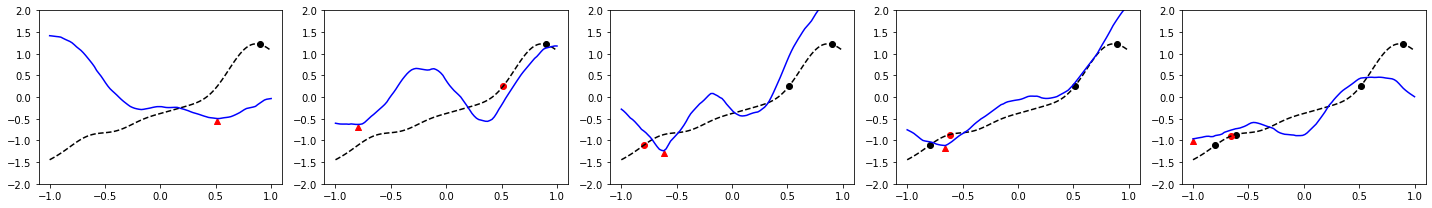

In [400]:
plot_thompson_process(samples, points, x.flatten(), y)